Author Yizhou Li, e-mail: lyzpp2000@163.com

Housing Price Prediction Assignment

Problem Statement:

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling<br>
or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences<br>
price negotiations than the number of bedrooms or a white-picket fence.<br>
<br>
With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition<br>
challenges you to predict the final price of each home.

Steps:

Importing modules

In [41]:
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

## Helper functions && some important fields

In [42]:
def load_data():
    file_path = "input/house-prices-advanced-regression-techniques/"
    train_df = pd.read_csv(file_path + "train.csv", index_col='Id')
    test_df = pd.read_csv(file_path + "test.csv", index_col='Id')    
    print(train_df.head(), "\n")
    print(train_df.info(), "\n")

    return train_df, test_df

def drop_duplicates(train_df, test_df) -> None :
    print("train DataFrame before droping the duplicates: row: ", train_df.shape[0], ", columns: ", train_df.shape[1])
    train_df.drop_duplicates(inplace=True)
    print("train DataFrame after droping the duplicates: row: ", train_df.shape[0], ", columns: ", train_df.shape[1], "\n")
    print("test DataFrame before droping the duplicates: row: ", train_df.shape[0], ", columns: ", train_df.shape[1])
    test_df.drop_duplicates(inplace=True)
    print("test DataFrame after droping the duplicates: row: ", train_df.shape[0], ", columns: ", train_df.shape[1], "\n")

def drop_columns_missing_above_80_percent(train_df, test_df) -> None :
    null_series = train_df.isnull().sum().sort_values(ascending=False)
    print("columns have null values:\n", null_series, "\n", sep="")
    temp_lst = []
    for i,v in null_series.items():
        if v / train_df.shape[0] >= 0.8:
            temp_lst.append(i)
    train_df.drop(temp_lst, axis=1, inplace=True)
    null_series = train_df.isnull().sum().sort_values(ascending=False)
    print("after we drop the columns that miss 80 percent values:\n", null_series, sep="")

    null_series = test_df.isnull().sum().sort_values(ascending=False)
    print("columns have null values:\n", null_series, "\n", sep="")
    temp_lst = []
    for i,v in null_series.items():
        if v / test_df.shape[0] >= 0.8:
            temp_lst.append(i)
    test_df.drop(temp_lst, axis=1, inplace=True)
    null_series = test_df.isnull().sum().sort_values(ascending=False)
    print("after we drop the columns that miss 80 percent values:\n", null_series, sep="")

def fill_na(train_df, test_df) -> None :
    for i, l in train_df.iteritems():
        if l.dtype == "object":
            l.fillna(value="Na", inplace=True)
        else:
            l.fillna(value=l.mean(), inplace=True)
    for i, l in test_df.iteritems():
        if l.dtype == "object":
            l.fillna(value="Na", inplace=True)
        else:
            l.fillna(value=l.mean(), inplace=True)

# 1. Data loading and exploring

In [43]:
train_df, test_df = load_data()

    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ... 

# 2. Data cleaning and preprating

In [44]:
drop_duplicates(train_df, test_df)

drop_columns_missing_above_80_percent(train_df, test_df)

fill_na(train_df, test_df)

print(train_df.head())
print(train_df.info())

print(test_df.head())
print(test_df.info())

train DataFrame before droping the duplicates: row:  1460 , columns:  80
train DataFrame after droping the duplicates: row:  1460 , columns:  80 

test DataFrame before droping the duplicates: row:  1460 , columns:  80
test DataFrame after droping the duplicates: row:  1460 , columns:  80 

columns have null values:
PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
Heating           0
HeatingQC         0
MSZoning          0
1stFlrSF          0
SalePrice         0
Length: 80, dtype: int64

after we drop the columns that miss 80 percent values:
FireplaceQu     690
LotFrontage     259
GarageType       81
GarageYrBlt      81
GarageFinish     81
               ... 
TotalBsmtSF       0
Heating           0
MSZoning          0
CentralAir        0
SalePrice         0
Length: 76, dtype: int64
columns have null values:
PoolQC           1456
MiscFeature      1408
Alley            1352
Fence            1169
FireplaceQu       730


# 3. Data visualization

plotting the predictor factor with the target factor.

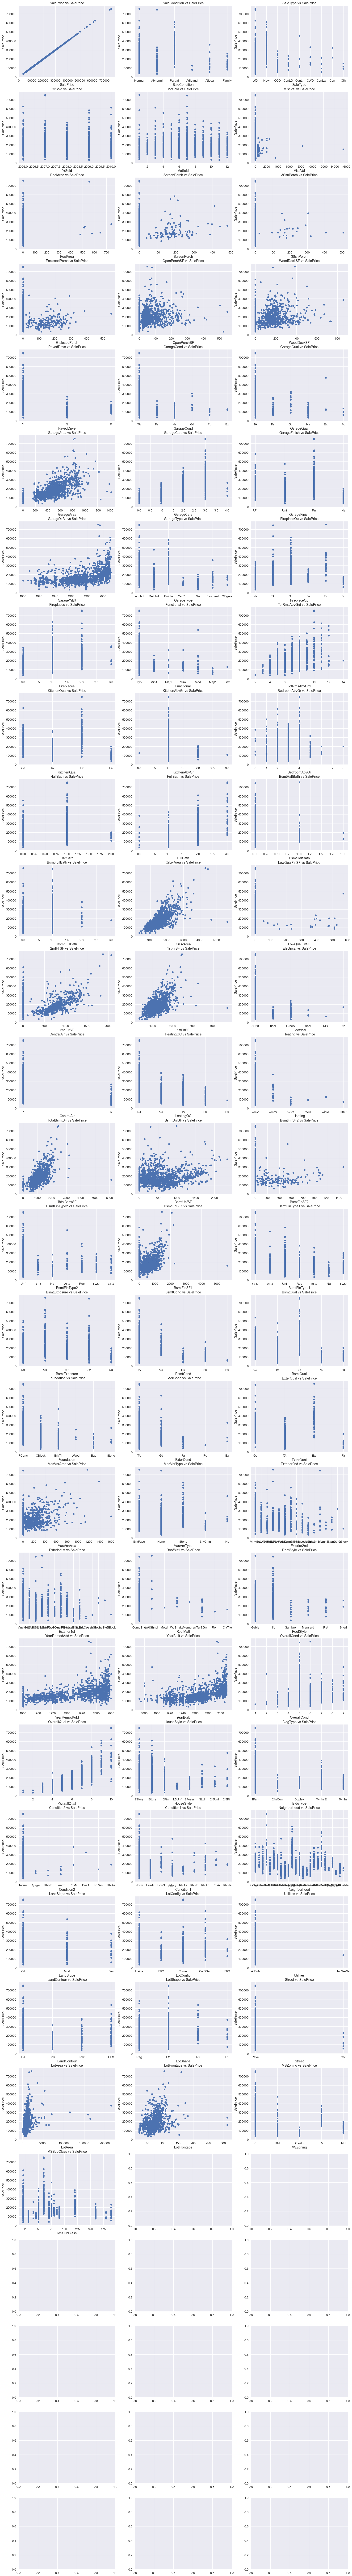

In [51]:
fig, axs = plt.subplots(30, 3)
my_lst = [col for col in train_df.columns]
fig.set_size_inches(25, 200)
row = 30
col = 3
y = train_df["SalePrice"]
for i in range(row):
    for j in range(col):
        if len(my_lst) == 0:
            break
        x = train_df[my_lst.pop()]
        axs[i, j].scatter(x, y)
        axs[i, j].set_xlabel(x.name)
        axs[i, j].set_ylabel("SalePrice")
        axs[i, j].set_title(x.name + " vs SalePrice")

# 4. Data preparation


In [60]:
x_data = train_df[['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea',
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']]
y_data = train_df["SalePrice"]
# my_train_lst = [col for col in train_df.columns]
# my_test_lst = [col for col in test_df.columns]
# my_train_lst.pop()
# my_test_lst.pop()

# x_data = train_df[my_train_lst]
# test_data = test_df[my_test_lst]
test_data = test_df[ ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea',
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)

# 5. Models building, evaluation, and predicting


In [61]:
model = LinearRegression()
model2 = Lasso()
model3 = Ridge()
model4 = DecisionTreeRegressor()
model5 = RandomForestRegressor()

model.fit(X=x_train, y=y_train)
model2.fit(X=x_train, y=y_train)
model3.fit(X=x_train, y=y_train)
model4.fit(X=x_train, y=y_train)
model5.fit(X=x_train, y=y_train)

print("the accuracy score using with LinearRegression() model ", model.score(x_test, y_test))
print("the accuracy score using with Lasso() model ", model2.score(x_test, y_test))
print("the accuracy score using with Ridge() model ", model3.score(x_test, y_test))
print("the accuracy score using with DecisionTreeRegressor() model ", model4.score(x_test, y_test))
print("the accuracy score using with RandomForestRegressor() model ", model5.score(x_test, y_test))

model.fit(X=x_train, y=y_train)
result = model.predict(test_data)
temp = test_df
temp.reset_index(inplace=True)
metric = pd.Series(result, name = 'SalePrice')
final_metric = pd.concat([temp["Id"], metric], axis = 1)
final_metric.to_csv("submission.csv",index =False)

the accuracy score using with LinearRegression() model  0.699274404306837
the accuracy score using with Lasso() model  0.699255842859624
the accuracy score using with Ridge() model  0.6988298969020352
the accuracy score using with DecisionTreeRegressor() model  0.5258261751040558
the accuracy score using with RandomForestRegressor() model  0.647976119535729


ValueError: cannot insert level_0, already exists